# Image Segmentation Model - MONAI

##### Imports

In [12]:
import torch
import monai
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    LoadImaged,
    RandSpatialCrop,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.networks.nets import UNet
from monai.networks.blocks import Convolution
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import CacheDataset, DataLoader, Dataset, ImageReader, MetaTensor
from monai.inferers import sliding_window_inference
from monai.transforms import Activations, AsDiscrete, KeepLargestConnectedComponent
from monai.visualize import plot_2d_or_3d_image
monai.utils.set_determinism(17)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

from skimage.io import imread, imsave, imshow

from tqdm import tqdm

import datetime

##### Hyperparamters

In [13]:
batch_size = 4
num_workers = 4
learning_rate = 0.0005
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Dataset Creation

In [14]:
class CellDataset(Dataset):
    def __init__(self, data_dir, train=True):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'image')
        self.mask_dir = os.path.join(data_dir, 'mask')
        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform_list = [
            RandFlip(prob=1, spatial_axis=0),
            RandFlip(prob=1, spatial_axis=1),
            RandRotate(prob=1, range_y=[1.57, 1.57]),
            RandRotate(prob=1, range_y=[4.71, 4.71])
        ]

        if train:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
        else:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
            self.image_files, self.test_image_files = self.test_image_files, self.image_files
            self.mask_files, self.test_mask_files = self.test_mask_files, self.mask_files
        
        self.temp_image_file = []
        self.temp_mask_file = []
        
        for image_path, mask_path in zip(self.image_files, self.mask_files):
            image_path = os.path.join(self.image_dir, image_path)
            mask_path = os.path.join(self.mask_dir, mask_path)
            image = MetaTensor(imread(image_path))
            mask = MetaTensor(imread(mask_path)).unsqueeze(0)
            self.temp_image_file.append(image)
            self.temp_mask_file.append(mask)
            for transform in self.transform_list:
                self.temp_image_file.append(transform(image))
                self.temp_mask_file.append(transform(mask))
        
        self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image = self.image_files[index].float()
        mask = torch.where(self.mask_files[index].float() == 0, 0.0, 1.0)

        return image, mask

In [15]:
DATA_DIR = r"D:\multiplexed-immunofluorescence-instance-segmentation\data\final"
train_dataset = CellDataset(DATA_DIR)
test_dataset = CellDataset(DATA_DIR, train=False)

In [16]:
train_dataset.__len__(), test_dataset.__len__()

(530, 135)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=torch.cuda.is_available())

In [18]:
len(train_loader), len(test_loader)

(133, 34)

##### Model Definition - UNet

In [19]:
in_channels = 8
out_channels = 1
model = UNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

In [20]:
# model._modules['model']._modules['2']._modules['1']._modules['conv']._modules['unit0']._modules['conv'] = Convolution(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=1,
#     kernel_size=3,
#     strides=1,
#     padding=1,
#     act=("sigmoid")
# )
model = model.to(device)
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

##### Loss Function and Optimizer

In [21]:
criterion = DiceLoss(sigmoid=True, jaccard=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

##### Training Loop

In [22]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute the loss
        loss = criterion(outputs, masks)
        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, masks)

            test_loss += loss.item() * images.size(0)

        test_loss /= len(test_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  3%|▎         | 1/30 [00:08<04:07,  8.54s/it]

Epoch 1/30, Train Loss: 0.4633, Test Loss: 0.4158


  7%|▋         | 2/30 [00:16<03:48,  8.15s/it]

Epoch 2/30, Train Loss: 0.4103, Test Loss: 0.3733


 10%|█         | 3/30 [00:24<03:34,  7.94s/it]

Epoch 3/30, Train Loss: 0.3741, Test Loss: 0.3419


 13%|█▎        | 4/30 [00:31<03:25,  7.89s/it]

Epoch 4/30, Train Loss: 0.3455, Test Loss: 0.3144


 17%|█▋        | 5/30 [00:39<03:17,  7.90s/it]

Epoch 5/30, Train Loss: 0.3227, Test Loss: 0.2975


 20%|██        | 6/30 [00:47<03:10,  7.96s/it]

Epoch 6/30, Train Loss: 0.3068, Test Loss: 0.2816


 23%|██▎       | 7/30 [00:55<03:03,  7.98s/it]

Epoch 7/30, Train Loss: 0.2920, Test Loss: 0.2730


 27%|██▋       | 8/30 [01:04<02:58,  8.11s/it]

Epoch 8/30, Train Loss: 0.2819, Test Loss: 0.2681


 30%|███       | 9/30 [01:13<02:55,  8.33s/it]

Epoch 9/30, Train Loss: 0.2712, Test Loss: 0.2578


 33%|███▎      | 10/30 [01:21<02:48,  8.40s/it]

Epoch 10/30, Train Loss: 0.2612, Test Loss: 0.2551


 37%|███▋      | 11/30 [01:30<02:43,  8.62s/it]

Epoch 11/30, Train Loss: 0.2503, Test Loss: 0.2532


 40%|████      | 12/30 [01:40<02:39,  8.85s/it]

Epoch 12/30, Train Loss: 0.2398, Test Loss: 0.2480


 43%|████▎     | 13/30 [01:49<02:32,  8.95s/it]

Epoch 13/30, Train Loss: 0.2314, Test Loss: 0.2454


 47%|████▋     | 14/30 [01:58<02:24,  9.03s/it]

Epoch 14/30, Train Loss: 0.2230, Test Loss: 0.2457


 50%|█████     | 15/30 [02:07<02:16,  9.10s/it]

Epoch 15/30, Train Loss: 0.2138, Test Loss: 0.2436


 53%|█████▎    | 16/30 [02:17<02:07,  9.12s/it]

Epoch 16/30, Train Loss: 0.2067, Test Loss: 0.2433


 57%|█████▋    | 17/30 [02:26<02:00,  9.26s/it]

Epoch 17/30, Train Loss: 0.1999, Test Loss: 0.2432


 60%|██████    | 18/30 [02:37<01:57,  9.82s/it]

Epoch 18/30, Train Loss: 0.1946, Test Loss: 0.2468


 63%|██████▎   | 19/30 [02:48<01:50, 10.06s/it]

Epoch 19/30, Train Loss: 0.1904, Test Loss: 0.2414


 67%|██████▋   | 20/30 [02:58<01:41, 10.13s/it]

Epoch 20/30, Train Loss: 0.1851, Test Loss: 0.2429


 70%|███████   | 21/30 [03:09<01:31, 10.22s/it]

Epoch 21/30, Train Loss: 0.1804, Test Loss: 0.2423


 73%|███████▎  | 22/30 [03:19<01:21, 10.21s/it]

Epoch 22/30, Train Loss: 0.1779, Test Loss: 0.2404


 77%|███████▋  | 23/30 [03:29<01:12, 10.32s/it]

Epoch 23/30, Train Loss: 0.1745, Test Loss: 0.2383


 80%|████████  | 24/30 [03:40<01:02, 10.38s/it]

Epoch 24/30, Train Loss: 0.1712, Test Loss: 0.2427


 83%|████████▎ | 25/30 [03:51<00:52, 10.53s/it]

Epoch 25/30, Train Loss: 0.1680, Test Loss: 0.2424


 87%|████████▋ | 26/30 [04:02<00:43, 10.75s/it]

Epoch 26/30, Train Loss: 0.1653, Test Loss: 0.2408


 90%|█████████ | 27/30 [04:13<00:32, 10.72s/it]

Epoch 27/30, Train Loss: 0.1626, Test Loss: 0.2396


 93%|█████████▎| 28/30 [04:24<00:21, 10.78s/it]

Epoch 28/30, Train Loss: 0.1626, Test Loss: 0.2398


 97%|█████████▋| 29/30 [04:35<00:10, 10.87s/it]

Epoch 29/30, Train Loss: 0.1593, Test Loss: 0.2374


100%|██████████| 30/30 [04:46<00:00,  9.53s/it]

Epoch 30/30, Train Loss: 0.1585, Test Loss: 0.2411


In [32]:
# Save the trained model
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"segmentation_model_monai_{timestamp}.pth"
save_path = f"../models/segmentation_model/{model_name}"
torch.save(model.state_dict(), save_path)

In [24]:
image, mask = test_dataset.__getitem__(30)

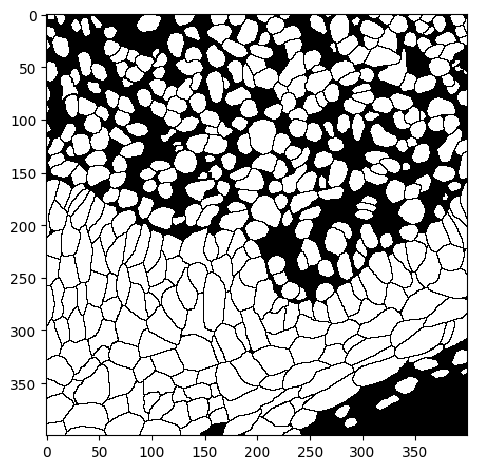

In [25]:
imshow(mask.squeeze().numpy(), cmap="gray")

In [26]:
sam_output = model(image.unsqueeze(0).to(device))

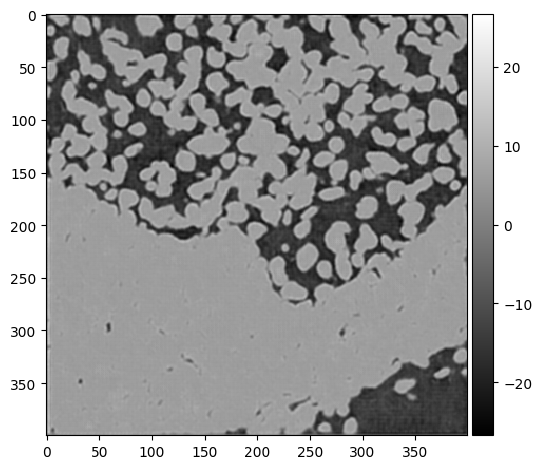

In [27]:
imshow(sam_output.squeeze().detach().cpu().numpy(), cmap="gray")

In [28]:
scaled_tensor = (sam_output - torch.min(sam_output)) * (1.0 / (torch.max(sam_output) - torch.min(sam_output)))

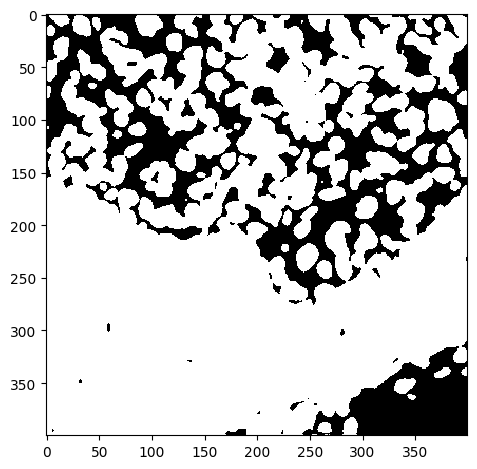

In [29]:
imshow(torch.round(scaled_tensor).detach().cpu().numpy().squeeze(), cmap='gray')